# Comparison of span vs other peak calling tools

Method based on F score described in original paper:
Koohy H, Down TA, Spivakov M, Hubbard T (2014) 
A Comparison of Peak Callers Used for DNase-Seq Data. 
PLoS ONE 9(5): e96303. doi:10.1371/journal.pone.0096303

http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0096303

## Requirements

* span.jar
* java8
* bedtools
* wget
* awk
* ~20G free space to download all the required bed and bam files

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import sys
from os import listdir
def run(cmd):
    print(cmd)
    if os.system(cmd) != 0:
        sys.exit(1)

Lets download all the "Reference peaks set" mentioned in http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0096303



In [2]:
! mkdir ~/data/2023_opendnase
! cd ~/data/2023_opendnase && wget "http://journals.plos.org/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0096303.s007" -O supplementary.zip
! cd ~/data/2023_opendnase && unzip -x supplementary.zip

--2023-06-21 12:17:57--  http://journals.plos.org/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0096303.s007
Resolving journals.plos.org (journals.plos.org)... 35.190.43.188
Connecting to journals.plos.org (journals.plos.org)|35.190.43.188|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://journals.plos.org:443/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0096303.s007 [following]
--2023-06-21 12:17:57--  https://journals.plos.org/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0096303.s007
Connecting to journals.plos.org (journals.plos.org)|35.190.43.188|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /plosone/article/file?id=info%3Adoi/10.1371/journal.pone.0096303.s007&type=supplementary [following]
--2023-06-21 12:17:57--  https://journals.plos.org/plosone/article/file?id=info%3Adoi/10.1371/journal.pone.0096303.s007&type=supplementary
Reusing existi

Now that we have Supplemetary_Data/GM12878.txt, etc, we can download all the peaks automatically.
Files are available here: http://journals.plos.org/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0096303.s007

In [4]:
import pandas as pd
PATH = os.path.expanduser('~/data/2023_opendnase')
RESOURCE = 'http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeSydhTfbs'
CELLS = ['GM12878', 'HelaS3', 'K562']
for cell in tqdm(CELLS):
    print(cell)
    os.mkdir(PATH + '/' + cell)
    df = pd.read_csv(PATH + f'/Supplementary_Data/{cell}.txt', sep=' ', header=None)
    df.columns = ['file', 'checksum']
    for f in df['file']:
        ! cd {PATH} && wget {RESOURCE}/{f} -P {cell}

  0%|          | 0/3 [00:00<?, ?it/s]

GM12878
--2023-06-21 12:20:33--  http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeSydhTfbs/wgEncodeSydhTfbsGm12878Bhlhe40cIggmusPk.narrowPeak.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1086634 (1,0M) [application/x-gzip]
Saving to: ‘GM12878/wgEncodeSydhTfbsGm12878Bhlhe40cIggmusPk.narrowPeak.gz’

wgEncodeSydhTfbsGm1 100%[===================>]   1,04M  1,09MB/s    in 0,9s    

2023-06-21 12:20:36 (1,09 MB/s) - ‘GM12878/wgEncodeSydhTfbsGm12878Bhlhe40cIggmusPk.narrowPeak.gz’ saved [1086634/1086634]

--2023-06-21 12:20:36--  http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeSydhTfbs/wgEncodeSydhTfbsGm12878Brca1a300IggmusPk.narrowPeak.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc

Now we should all the reference peaks using Bedops as described in the article, however Bedops FAILS with segfault.

Bedtools for the rescue!

In [6]:
# Lets merge them and filter chr22 to get reference peaks
CELLS = ['GM12878', 'HelaS3', 'K562']
! mkdir {PATH}/peaks
for cell in tqdm(CELLS):
    ! cd {PATH} && cat {cell}/*.gz > {cell}_all.bed
    ! bedtools sort -i {PATH}/{cell}_all.bed > {PATH}/{cell}_sorted.bed
    ! bedtools merge -i {PATH}/{cell}_sorted.bed > {PATH}/{cell}_peaks.bed
    run(f'awk \'$1=="chr22" {{print}}\' {PATH}/{cell}_peaks.bed > {PATH}/peaks/{cell}_peaks_chr22.bed')
! rm *_all.bed *_sorted.bed *_peaks.bed

mkdir: cannot create directory ‘/home/jetbrains/data/2023_opendnase/peaks’: File exists


  0%|          | 0/3 [00:00<?, ?it/s]

awk '$1=="chr22" {print}' /home/jetbrains/data/2023_opendnase/GM12878_peaks.bed > /home/jetbrains/data/2023_opendnase/peaks/GM12878_peaks_chr22.bed
awk '$1=="chr22" {print}' /home/jetbrains/data/2023_opendnase/HelaS3_peaks.bed > /home/jetbrains/data/2023_opendnase/peaks/HelaS3_peaks_chr22.bed
awk '$1=="chr22" {print}' /home/jetbrains/data/2023_opendnase/K562_peaks.bed > /home/jetbrains/data/2023_opendnase/peaks/K562_peaks_chr22.bed


Download and convert reads.

In [7]:
! wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseK562AlnRep1.bam -O {PATH}/K562.bam
! wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseGm12878AlnRep1.bam -O {PATH}/GM12878.bam
! wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseHelas3AlnRep1.bam -O {PATH}/HelaS3.bam

print('Lets convert downloaded bam files to bed')
for bam in tqdm([f for f in listdir(PATH) if f.endswith(".bam")]):
    ! bamToBed -bed12 -i {PATH}/{bam} > {PATH}/{bam}.bed

--2023-06-21 12:26:09--  http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseK562AlnRep1.bam
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1471059366 (1,4G) [application/octet-stream]
Saving to: ‘/home/jetbrains/data/2023_opendnase/K562.bam’

/home/jetbrains/dat 100%[===================>]   1,37G  12,0MB/s    in 2m 38s  

2023-06-21 12:28:47 (8,88 MB/s) - ‘/home/jetbrains/data/2023_opendnase/K562.bam’ saved [1471059366/1471059366]

--2023-06-21 12:28:47--  http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseGm12878AlnRep1.bam
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting respo

  0%|          | 0/3 [00:00<?, ?it/s]

Now we can launch span to get enrichment for obtained bed tracks.

In [10]:
! cd {PATH} && wget https://download.jetbrains.com/biolabs/span/span-1.1.5628.jar
! cd {PATH} && wget http://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.chrom.sizes

--2023-06-21 12:39:48--  https://download.jetbrains.com/biolabs/span/span-1.1.5628.jar
Resolving download.jetbrains.com (download.jetbrains.com)... 3.248.40.89, 54.220.183.129, 2a05:d018:13b2:dd02:9836:8c9e:7b18:af0a, ...
Connecting to download.jetbrains.com (download.jetbrains.com)|3.248.40.89|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://download-cdn.jetbrains.com/biolabs/span/span-1.1.5628.jar [following]
--2023-06-21 12:39:48--  https://download-cdn.jetbrains.com/biolabs/span/span-1.1.5628.jar
Resolving download-cdn.jetbrains.com (download-cdn.jetbrains.com)... 13.227.219.113, 13.227.219.11, 13.227.219.47, ...
Connecting to download-cdn.jetbrains.com (download-cdn.jetbrains.com)|13.227.219.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34438415 (33M) [binary/octet-stream]
Saving to: ‘span-1.1.5628.jar’

span-1.1.5628.jar   100%[===================>]  32,84M  51,2MB/s    in 0,6s    

2023-06-21 12:39

In [60]:
! mkdir {PATH}/span
FDRS = [1e-8, 1e-6, 1e-4, 1e-3, 0.05, 0.1, 0.2]
for reads in tqdm([f for f in listdir(PATH) if f.endswith(".bam.bed")]):
    for fdr in FDRS:
        print(f'Processing {reads} FDR={fdr}')
        ! cd {PATH} && java -jar span-1.1.5628.jar analyze -cs hg19.chrom.sizes \
                -t {reads} --peaks span/{reads}_{fdr}_span.bed --bin 100 --fdr {fdr} --gap 3 --clip

mkdir: cannot create directory ‘/home/jetbrains/data/2023_opendnase/span’: File exists


  0%|          | 0/3 [00:00<?, ?it/s]

Processing K562.bam.bed FDR=1e-08
[Jun 22, 2023 14:43:06] SPAN 1.1.build built on June 22, 2023
[Jun 22, 2023 14:43:06] COMMAND: analyze -cs hg19.chrom.sizes -t K562.bam.bed --peaks span/K562.bam.bed_1e-08_span.bed --bin 100 --fdr 1e-08 --gap 3 --clip
[Jun 22, 2023 14:43:06] LOG: /home/jetbrains/data/2023_opendnase/logs/K562.bam.bed_1e-08_span.log
[Jun 22, 2023 14:43:06] WORKING DIR: /home/jetbrains/data/2023_opendnase
[Jun 22, 2023 14:43:06] TREATMENT: /home/jetbrains/data/2023_opendnase/K562.bam.bed
[Jun 22, 2023 14:43:06] CONTROL: none
[Jun 22, 2023 14:43:06] CHROM.SIZES: /home/jetbrains/data/2023_opendnase/hg19.chrom.sizes
[Jun 22, 2023 14:43:06] BIN: 100
[Jun 22, 2023 14:43:06] FRAGMENT: auto
[Jun 22, 2023 14:43:06] KEEP DUPLICATES: false
[Jun 22, 2023 14:43:06] CONVERGENCE THRESHOLD: 1.0
[Jun 22, 2023 14:43:06] MAX ITERATIONS: 20
[Jun 22, 2023 14:43:06] MODEL TYPE: Negative binomial HMM 2 states with zero inflation
[Jun 22, 2023 14:43:06] FDR: 1.0E-8
[Jun 22, 2023 14:43:06] GAP: 

    Let us perform intersection of reference peaks with span ones.

In [61]:
import tempfile
import pandas as pd
from pandas import DataFrame

def bed_length(cell_file):
    t = pd.read_csv(cell_file,  sep='\t', header=None)
    if len(t) > 0:
        return (t[2] - t[1]).sum()
    return 0

def lines(cell_file):
    t = pd.read_csv(cell_file,  sep='\t', header=None)
    return len(t)

t = tempfile.mktemp()

results = DataFrame(columns=['cell', 'fdr', 'ref_peaks', 'ref_length',
                             'span_peaks', 'span_length', 'intersection_peaks', 'intersection_length'])
for cell in tqdm(CELLS):
    cell_file = f'{PATH}/peaks/{cell}_peaks_chr22.bed'
    cell_peaks = lines(cell_file)
    cell_peaks_length = bed_length(cell_file)    
    
    for reads in [f for f in listdir(PATH) if f.endswith(".bam.bed")]:
        for fdr in FDRS: 
            file = f'{PATH}/span/{reads}_{fdr}_span.bed'
            if (cell not in file):
                continue
            ! cat {file} | grep chr22 > {t}
            span_peaks = lines(t)
            span_length = bed_length(t)
            intersection_file = f'{PATH}/peaks/intersection_{cell}_{fdr}.bed'
            ! bedtools intersect -a {cell_file} -b {t} > {intersection_file}
            intersection_peaks = lines(intersection_file)
            intersection_length = bed_length(intersection_file)
            results.loc[len(results)] = [cell, fdr, cell_peaks, cell_peaks_length,
                                         span_peaks, span_length, intersection_peaks, intersection_length]
results

  0%|          | 0/3 [00:00<?, ?it/s]

,cell,fdr,ref_peaks,ref_length,span_peaks,span_length,intersection_peaks,intersection_length
0,GM12878,1.000000e-08,6253,3107182,1247,835638,1279,787215
1,GM12878,1.000000e-06,6253,3107182,1382,1113471,1488,982433
2,GM12878,1.000000e-04,6253,3107182,1499,1553173,1787,1205174
3,GM12878,1.000000e-03,6253,3107182,1544,1797815,1949,1310978
4,GM12878,5.000000e-02,6253,3107182,1720,2104887,2193,1434341
5,GM12878,1.000000e-01,6253,3107182,1803,2120426,2236,1440931
6,GM12878,2.000000e-01,6253,3107182,1832,2318347,2330,1519114
7,HelaS3,1.000000e-08,4582,2484251,961,481515,929,459455
8,HelaS3,1.000000e-06,4582,2484251,1065,577645,1027,541429
9,HelaS3,1.000000e-04,4582,2484251,1196,719625,1142,650341


Now that we have both reference peaks, span output and their intersection length, we can compute `TP`, `FP` and `FN` values.

In [62]:
results['TP'] = results['intersection_length']
results['FP'] = results['span_length'] - results['intersection_length']
results['FN'] = results['ref_length'] - results['intersection_length']
results['Spec'] = results['TP'] / (results['TP'] + results['FP'])
results['Sen'] = results['TP'] / (results['TP'] + results['FN'])
results.head(1)

,cell,fdr,ref_peaks,ref_length,span_peaks,span_length,intersection_peaks,intersection_length,TP,FP,FN,Spec,Sen
0,GM12878,1.000000e-08,6253,3107182,1247,835638,1279,787215,787215,48423,2319967,0.942053,0.253353


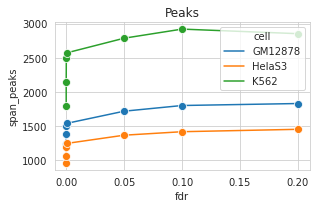

In [63]:
import seaborn as sns
plt.figure(figsize=(4.5, 3))
g_results = sns.lineplot(data=results,
                         x='fdr', y='span_peaks', hue='cell',
                         errorbar='se', marker='o', markersize=8)
g_results.axes.title.set_text(f'Peaks')
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_jaccard2.pdf', bbox_inches='tight', dpi=300)
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

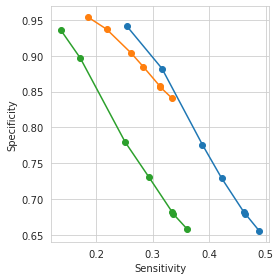

In [64]:
plt.figure(figsize=(4, 4))
for cell in tqdm(CELLS):
    t = results[results['cell'] == cell].copy()
    t.sort_values(by=['Sen', 'Spec'], inplace=True)
    plt.plot(t['Sen'], t['Spec'], marker='o', label=cell)
plt.xlabel('Sensitivity')
plt.ylabel('Specificity')
plt.tight_layout()
plt.show()

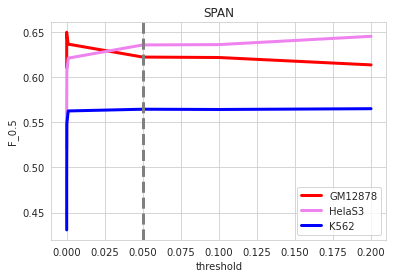

In [65]:
CELLS = ['GM12878', 'HelaS3', 'K562']
def Fb(b, spec, sen):
    return (1 + b*b) * spec * sen / (b * b * spec + sen)

Beta = 0.5
colors = {'GM12878': 'red', 'K562': 'blue', 'HelaS3':'violet'}
plt.title('SPAN')
plt.xlabel('threshold')
plt.ylabel('F_0.5')
for cell in CELLS:
    r = results[results['cell'] == cell]
    plt.plot(r['fdr'], Fb(Beta, r['Spec'], r['Sen']), linewidth=3.0, c=colors[cell], label=cell)
plt.axvline(x=0.05, linewidth=3.0, c='grey', linestyle='--')
plt.legend()
plt.show()

### Now we are ready to compare performance score F
<img src="SPAN Comparison Opendnase.png">